## Stat 143 Project 2: Fourth Down
Author: Janet Li

In [1]:
import pandas as pd
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load data
DATADIR = ''
nfl_pbp = pd.read_csv(DATADIR + 'NFL_PbP_2009_2018_4thDownAnalysis.csv')

In [3]:
# smoothing functions
def nonparam_smooth(y,smooth_type='savgol',window=21):
    if smooth_type=='savgol':
        y[~np.isnan(y)] = signal.savgol_filter(y[~np.isnan(y)],window,2)
    return y

def poly_smooth(x,y,deg):
    nanvals = np.isnan(y)
    pfit,cov = np.polyfit(x[~nanvals],y[~nanvals],deg, cov=True)
    yp = np.poly1d(pfit)(x)
    return yp,pfit,cov

In [4]:
# max yards to go + 1
max_ytg = 16

## Going for it

In [5]:
# probability of 1st down given yards to go
plays = nfl_pbp[(nfl_pbp.play_type == 'pass') | (nfl_pbp.play_type == 'run')]
firstDown_prob = np.zeros(max_ytg-1)
for ytg in range(1, max_ytg):
    firstDown_prob[ytg-1] = np.mean(plays.yards_gained[plays.ydstogo == ytg] >= ytg)
    
# piecewise polynomial smooth
firstDown_poly = poly_smooth(np.arange(1,max_ytg), firstDown_prob.copy(), deg=3)[0]
firstDown_prob = dict(zip(range(1,max_ytg), firstDown_poly))

In [6]:
# expected value of 1st down given yardline
plays = nfl_pbp[nfl_pbp['down'] == 1]
firstDown_pts = {}
for yds in range(1,100):
    firstDown_pts[yds] = np.mean(plays[plays.yardline_100 == yds].next_score_relative_to_posteam)

In [7]:
# cost of turnover given yardline
firstDown_cost = {}
for yds in range(1,100):
    firstDown_cost[yds] = -1 * firstDown_pts[100-yds]

In [8]:
# expected points from touchdown

# expected points from 1 or 2 pt conversion
# P(1-pt conversion) * P(successful 1-pt conversion) + 2 * P(2-pt conversion) * P(successful 2-pt conversion)

one_pt_plays = np.sum(nfl_pbp.extra_point_attempt == 1)
two_pt_plays = np.sum(nfl_pbp.two_point_attempt == 1)

one_pt_prob = one_pt_plays / (one_pt_plays + two_pt_plays)
one_pt_success = np.mean(nfl_pbp[nfl_pbp.extra_point_attempt == 1].extra_point_result == 'good')
two_pt_success = np.mean(nfl_pbp[nfl_pbp.two_point_attempt == 1].two_point_conv_result == 'success')

extra_pts = one_pt_prob * one_pt_success + 2 * (1 - one_pt_prob) * two_pt_success

# average starting position after kickoff
kickoffs = nfl_pbp[nfl_pbp['kickoff_attempt'] == 1].index
kickoff_dist = round(np.mean(nfl_pbp.iloc[kickoffs+1].yardline_100))
kickoff_dist

# expected points from touchdown
td_pts = 6 + extra_pts - firstDown_pts[kickoff_dist]
td_pts

6.071859914989405

In [9]:
# expected value of going for it, given yardline and yards to go

goforit = {}
for yardline in range(1, 100):
    yardline_value = {}
    for ytg in range(1, max_ytg):
        if yardline == ytg: # score touchdown
            yardline_value[ytg] = firstDown_prob[ytg]*td_pts + (1-firstDown_prob[ytg])*firstDown_cost[yardline]
        elif yardline > ytg:
            yardline_value[ytg] = firstDown_prob[ytg]*firstDown_pts[yardline-ytg] + (1-firstDown_prob[ytg])*firstDown_cost[yardline]
    goforit[yardline] = yardline_value


## Field goal

In [10]:
# probability of field goal given yardline
plays = nfl_pbp[nfl_pbp['field_goal_attempt']==1]
fg_prob = np.zeros(99)
for i in range(50): # prob of field goal at any field position >= 50 is set to 0
    rows = plays.yardline_100==i+1
    fg_prob[i] = np.mean(plays[rows].posteam_score_post > plays[rows].posteam_score)

# nonparametric smooth
fg_nonparam = nonparam_smooth(fg_prob.copy(), window=21)
fg_nonparam[fg_nonparam < 0] = 0
fg_nonparam[fg_nonparam > 1] = 1

fg_prob = dict(zip(range(1,100),fg_prob))

In [11]:
# expected value of field goal given field position
fg = {}
fg_value = 3 - firstDown_pts[kickoff_dist] # value of field goal
for yds in range(1, 100):
    if yds < 92: # max field position for field goal is 92
        fg[yds] = fg_prob[yds]*fg_value - (1-fg_prob[yds])*firstDown_pts[min(80, 100-(yds+8))]
    else:
        fg[yds] = -10 # small value that will never be chosen

## Punt

In [12]:
# expected value of punt given field position
plays = nfl_pbp[nfl_pbp.play_type == "punt"]
punt = {}
for yds in range(1, 100):
    punt_dist = np.mean(plays[plays.yardline_100==yds].kick_distance) - np.mean(plays[plays.yardline_100==yds].return_yards)
    if punt_dist != punt_dist: # if nan, then touchback
        punt[yds] = -1 * firstDown_pts[80]
    else:
        punt[yds] = -1 * firstDown_pts[min(round(100-yds+punt_dist), 80)]

## Recommendations

In [13]:
# get optimal decision and expected points given yardline and yards to go
# for decision: 0 = impossible, 1 = go for it, 2 = field goal, 3 = punt
# for expected points: 300 = impossible
decision = np.zeros((max_ytg, 100))
points = np.zeros((max_ytg, 100))
points.fill(300)
for yardline in range(1,100):
    for ytg in range(1, min(yardline+1, max_ytg)):
        if yardline + ytg > 100:
            decision[ytg][yardline] = 0
            points[ytg][yardline] = 300
        else:
            decision[ytg][yardline] = np.array([goforit[yardline][ytg], fg[yardline], punt[yardline]]).argmax()+1
            points[ytg][yardline] = max([goforit[yardline][ytg], fg[yardline], punt[yardline]])

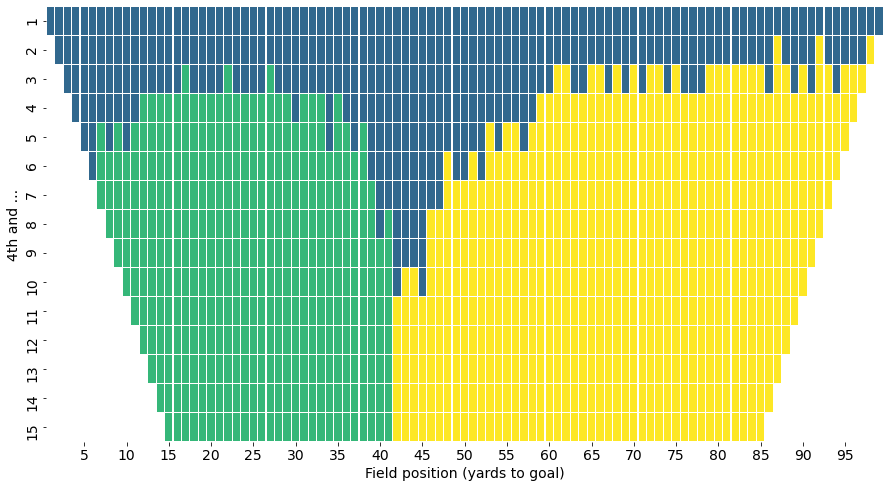

In [14]:
plt.figure(figsize=(15,8))
ax = sns.heatmap(decision, mask=np.ma.masked_values(decision, 0).mask, vmin=0, vmax=3, xticklabels=5, 
                 yticklabels=1, cmap='viridis', cbar=False, linewidths=.1)
plt.xlim(1,100)
plt.ylim(max_ytg,1)
plt.xlabel("Field position (yards to goal)")
plt.ylabel("4th and ...")
for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)
plt.show()

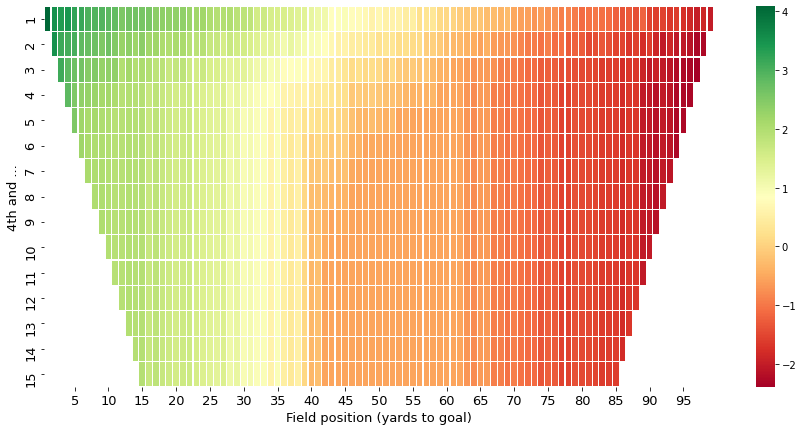

In [15]:
plt.figure(figsize=(15,7))
ax = sns.heatmap(points, mask=np.ma.masked_values(points, 300).mask, xticklabels=5, yticklabels=1, 
                 cmap='RdYlGn', cbar=True, linewidths=.1)
plt.xlim(1,100)
plt.ylim(max_ytg,1)
plt.xlabel("Field position (yards to goal)")
plt.ylabel("4th and ...")
for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(13)
plt.show()